In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math
import seaborn as sns


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


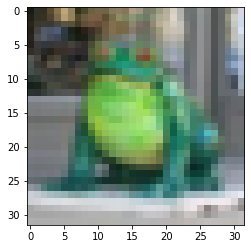

In [3]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

In [4]:
##### generate data ######

root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
    
def x_to_xaug(data, sample = 100, index = 0):
    '''
    Input : a list of picture, index of the pic we want, number of sample generate
    
    Output: list of pictures each have 2 random augmentations on it
    '''
    x = []
    original_pic = data[index][0]
    for i in range(sample):
        transform_pic = transform_train(original_pic)
        x.append(transform_pic)
    return x

def gen_data(B = 500, sample = 100):
    '''
    B = image batch
    num_aug = number of augmented picture for each image 
    
    return x_train, x_test (list) [[pic1_aug1, pic1_aug2, .....], [pic2_aug1, pic2_aug2, ...], ...]
    '''
    idx_train = np.random.randint(low = 0, high = len(train), size = B)
    idx__test = np.random.randint(low = 0, high = len(test), size = B)
    #sample augmented image !
    X_train = [x_to_xaug(data = train, sample = sample, index = idx_train[i]) for i in range(B)]
    X_test = [x_to_xaug(data = test, sample = sample, index = idx__test[i]) for i in range(B)]
    
    return X_train, X_test


# get data for x with only one sample for each image 
def gen_data_1pic(B = 100):
    '''
    the main difference between this function and gen_data is that this function return
    a list [augpic1, augpic2, ...., augpic n] each original picture is selected once
    '''
    train, test = gen_data(B=B, sample = 1)
    X_train1 = [train[i][0] for i in range(len(train))]
    X_test1 = [test[i][0] for i in range(len(test))]
    return [X_train1], [X_test1]


Files already downloaded and verified
Files already downloaded and verified


In [6]:
##### load checkpoint ! ######
def get_net(filename):
    '''
    Input: checkpoint filename
    Return: net, critic
     
    '''
    
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
    net.load_state_dict(checkpoint['net'])
    
    #load critics
    critics = LinearCritic(net.representation_dim, temperature=temperature).to(device)
    critics.load_state_dict(checkpoint['critic'])
    
    return net, critics

In [7]:
def x_to_h(x, net):
    '''
    Input x (list) , net, critics
    
    return h(list), for that list x
    '''
    h = []
    net.eval()
    with torch.no_grad():
        for i in range(len(x)):
            x_i = x[i].unsqueeze(0)
            h_i = net(x_i)
            h.append(h_i)
    return h

In [8]:
def h_to_z(h, critics):
    z = []
    critics.eval()
    with torch.no_grad():
        for i in range(len(h)):
            z_i = critics.project(h[i])
            z.append(z_i)
    return z

In [9]:
def h_to_cov(h):
    '''
    h = list(tensor1, tensor2, ...)
    
    return 512x512 covariance matrix 
    '''
    B = len(h)
    H_torch = torch.stack(h).squeeze(1)
    H_torch_mean = H_torch.mean(dim = 0)
    H_torch_mean = H_torch_mean.repeat(B,1)
    
    H_torch_norm = H_torch- H_torch_mean
    cov_H = 1/(B-1) * torch.matmul(H_torch_norm.transpose(0,1), H_torch_norm)
    
    return cov_H

In [10]:
def cov_to_trace(cov_H):
    '''
    return trace
    '''
    return cov_H.trace()

def cov_to_logdet(cov_H, buffer = 1):
    '''
    return logdet of covariance matrix
    '''
    return (cov_H + (torch.eye(cov_H.size()[0])).to(device)).det().log()

In [102]:
def x_to_cov(X, filename):
    net, critics = get_net(filename)
    
    cov_H = []
    cov_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        cov_H.append(cov_h_i)
        cov_Z.append(cov_z_i)
        
    return cov_H, cov_Z

def x_to_logdet(X, filename):
    net, critics = get_net(filename)
    
    logdet_H = []
    logdet_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        logdet_H.append(cov_to_logdet(cov_h_i))
        logdet_Z.append(cov_to_logdet(cov_z_i))
        
        
    return logdet_H, logdet_Z



def x_to_trace(X, filename):
    net, critics = get_net(filename)
    
    trace_H = []
    trace_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        trace_H.append(cov_to_trace(cov_h_i))
        trace_Z.append(cov_to_trace(cov_z_i))
        
    return trace_H, trace_Z
       
def Batch_x_to_value(X, checkpointfile, mode = 'trace'):
    if (mode == 'trace'):
        avg_trace_h = {}
        avg_trace_z = {}
        for filename in tqdm(checkpointfile):
            trace_H_i, trace_Z_i = x_to_trace(X, filename)
            avg_trace_H_i = torch.tensor(trace_H_i).mean()
            avg_trace_Z_i = torch.tensor(trace_Z_i).mean()

            avg_trace_h[filename] = avg_trace_H_i
            avg_trace_z[filename] = avg_trace_Z_i

        return avg_trace_h, avg_trace_z
    elif (mode == 'log_det'):
        avg_logdet_h = {}
        avg_logdet_z = {}
        for filename in tqdm(checkpointfile):
            logdet_H_i, logdet_Z_i = x_to_logdet(X, filename)
            avg_logdet_H_i = torch.tensor(logdet_H_i).mean()
            avg_logdet_Z_i = torch.tensor(logdet_Z_i).mean()

            avg_logdet_h[filename] = avg_logdet_H_i
            avg_logdet_z[filename] = avg_logdet_Z_i

        return avg_logdet_h, avg_logdet_z
            

In [126]:
def my_plot2(train_dict, test_dict, title = 'trace of covariance h|x' , label1 = 'train', label2 = 'test'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'r')
    plt.plot([99+ 100*i for i in range(10)], [test_dict[cp] for cp in checkpointfile], label = label2, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()
        
    
def my_plot1(train_dict, title = 'trace of covariance h|x', label1 = 'train'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()
    
def my_plot(my_list, title = 'best accuracy each checkpoint', label1 = 'best_acc'):
    plt.plot([99+ 100*i for i in range(10)], [my_list[i] for i in range(10)], label = label1, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

# Sanity check !

### plot with different value of B -> converge

In [91]:
#plot log det cov h against B
B_list = [10*i for i in range(1,20)]
logdet_H = []
logdet_Z = []
trace_H = []
trace_Z = []
for B in tqdm(B_list):
    X_train, X_test = gen_data_1pic(B = B)
    logdet_h, logdet_z = x_to_logdet(X_train, 'resnet18_new.pth399')
    trace_h, trace_z = x_to_trace(X_train, 'resnet18_new.pth399')
    
    logdet_H.append(logdet_h[0])
    logdet_Z.append(logdet_z[0])
    
    trace_H.append(trace_h[0])
    trace_Z.append(trace_z[0])
    

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


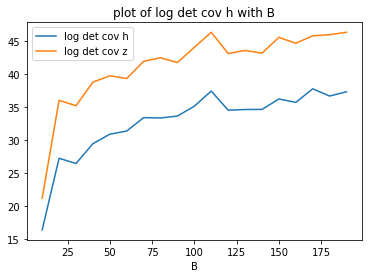

In [92]:
plt.plot(B_list, logdet_H,  label = 'log det cov h')
plt.plot(B_list, logdet_Z,  label = 'log det cov z')
plt.legend()
plt.xlabel('B')
plt.title('plot of log det cov h with B')
plt.show()

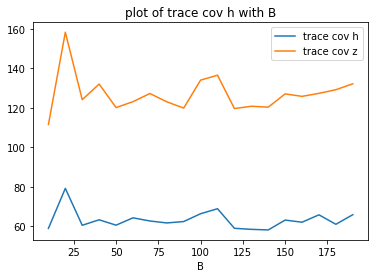

In [94]:
plt.plot(B_list, trace_H,  label = 'trace cov h')
plt.plot(B_list, trace_Z,  label = 'trace cov z')
plt.legend()
plt.xlabel('B')
plt.title('plot of trace cov h with B')
plt.show()

### Check with multivariate normal distribution

In [96]:
multi_norm_dist = torch.distributions.MultivariateNormal(torch.zeros([1, 3]), 
                                                         covariance_matrix = torch.eye(3))

cov_list = []
trace_list = []
logdet_list = []
for i in range(1,50):
    h_test = []
    for j in range(100*i):
        h_test.append(multi_norm_dist.sample().to(device))
    a = h_to_cov(h_test)
    b = cov_to_trace(a)
    c = cov_to_logdet(a, buffer = 0.1)
    cov_list.append(a)
    trace_list.append(b)
    logdet_list.append(c)

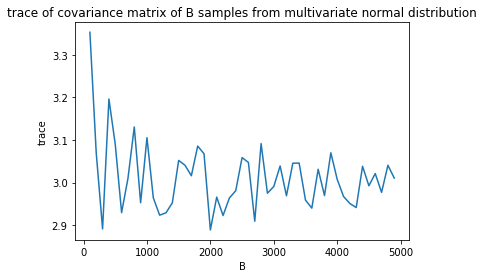

In [97]:
plt.plot([100*i for i in range(1,50)], trace_list)
plt.xlabel('B')
plt.ylabel('trace')
plt.title('trace of covariance matrix of B samples from multivariate normal distribution')
plt.show()

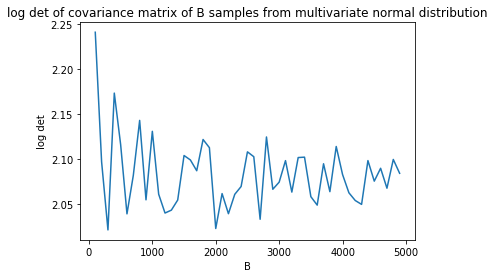

In [98]:
plt.plot([100*i for i in range(1,50)], logdet_list)
plt.xlabel('B')
plt.ylabel('log det')
plt.title('log det of covariance matrix of B samples from multivariate normal distribution')
plt.show()

### check convargence of the matrix

In [99]:
print('B = 100')
print(cov_list[0])

B = 100
tensor([[ 1.1688,  0.0431, -0.0264],
        [ 0.0431,  0.8959,  0.0376],
        [-0.0264,  0.0376,  1.2884]], device='cuda:0')


In [100]:
print('B = 2000')
print(cov_list[20])

B = 2000
tensor([[0.9464, 0.0119, 0.0115],
        [0.0119, 1.0258, 0.0170],
        [0.0115, 0.0170, 0.9938]], device='cuda:0')


In [101]:
print('B = 4000')
print(cov_list[40])

B = 4000
tensor([[ 1.0242, -0.0158, -0.0011],
        [-0.0158,  0.9832, -0.0150],
        [-0.0011, -0.0150,  0.9601]], device='cuda:0')


### check size h

In [103]:
B = 100
X_train1 , X_test1 = gen_data_1pic(B = B)
net, critics = get_net('resnet18_new.pth99')
H = x_to_h(X_train1[0], net)
Z = h_to_z(H, critics)

# h to covariance, z to covariance
cov_H = h_to_cov(H)
cov_Z = h_to_cov(Z)

In [104]:
cov_H.size()

torch.Size([512, 512])

In [105]:
cov_Z.size()

torch.Size([128, 128])

In [106]:
cov_to_logdet(cov_H)

tensor(73.8310, device='cuda:0')

In [107]:
cov_to_logdet(cov_Z)

tensor(39.2286, device='cuda:0')

### check size h|x 

In [114]:
X_train, X_test = gen_data(B = 20, sample = 10)

In [115]:
cov_H_x, cov_Z_x = x_to_cov(X_train, 'resnet18_new.pth99')

In [116]:
len(cov_H_x)

20

In [117]:
cov_H_x[0].size()

torch.Size([512, 512])

In [118]:
cov_Z_x[0].size()

torch.Size([128, 128])

### correctness check that trace of the resulted covariance is the same as we have from torch.var()

In [119]:
B = 100
X_train1 , X_test1 = gen_data_1pic(B = B)
net, critics = get_net('resnet18_new.pth99')
H = x_to_h(X_train1[0], net)
H_torch = torch.stack(H).squeeze(1)

In [120]:
H_torch.size()

torch.Size([100, 512])

In [122]:
H_torch.var(0).size()

torch.Size([512])

In [123]:
# trace from pytorch
H_torch.var(0).sum(0)

tensor(333.0717, device='cuda:0')

In [125]:
# trace from my function
cov_H = h_to_cov(H)
cov_H.trace()

tensor(333.0717, device='cuda:0')

# Look at covariance matrix of h|x, z|x

In [128]:
#Gendata
X_train, X_test = gen_data(B=100, sample = 50)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]

In [129]:
#Get trace
tr_cov_h_giv_x_train, tr_cov_z_giv_x_train = Batch_x_to_value(X_train, checkpointfile)

100%|██████████| 10/10 [02:55<00:00, 17.52s/it]


In [130]:
tr_cov_h_giv_x_test, tr_cov_z_giv_x_test = Batch_x_to_value(X_test, checkpointfile)

100%|██████████| 10/10 [03:06<00:00, 18.61s/it]


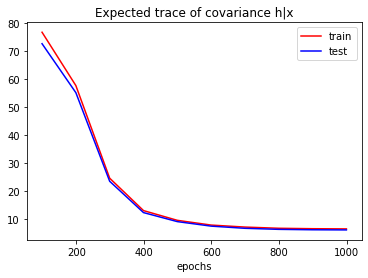

In [131]:
my_plot2(tr_cov_h_giv_x_train, tr_cov_h_giv_x_test, title = 'Expected trace of covariance h|x')

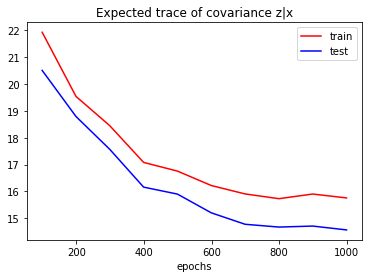

In [132]:
my_plot2(tr_cov_z_giv_x_train, tr_cov_z_giv_x_test, title = 'Expected trace of covariance z|x')

# Log det

In [133]:
logdet_cov_h_giv_x_train, logdet_cov_z_giv_x_train = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [03:23<00:00, 20.38s/it]


In [134]:
logdet_cov_h_giv_x_test, logdet_cov_z_giv_x_test = Batch_x_to_value(X_test, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [03:28<00:00, 20.84s/it]


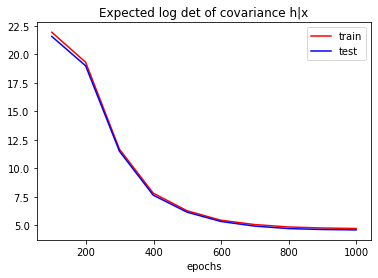

In [135]:
my_plot2(logdet_cov_h_giv_x_train, logdet_cov_h_giv_x_test, title = 'Expected log det of covariance h|x')

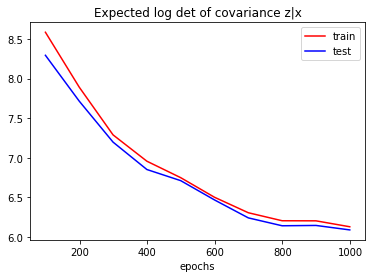

In [136]:
my_plot2(logdet_cov_z_giv_x_train, logdet_cov_z_giv_x_test, title = 'Expected log det of covariance z|x')

# Look at tr cov h/ log det cov h

In [137]:
X_train1 , X_test1 = gen_data_1pic(B = 300)

In [138]:
#Get trace
tr_cov_h_train, tr_cov_z_train = Batch_x_to_value(X_train1, checkpointfile, mode = 'trace')

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


In [139]:
tr_cov_h_test, tr_cov_z_test = Batch_x_to_value(X_test1, checkpointfile, mode = 'trace')

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


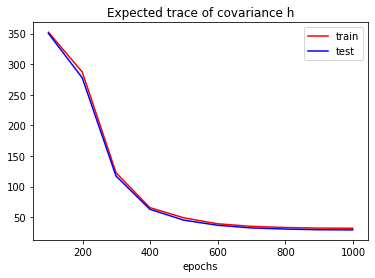

In [140]:
my_plot2(tr_cov_h_train, tr_cov_h_test, title = 'Expected trace of covariance h')

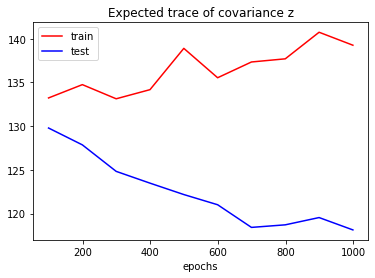

In [141]:
my_plot2(tr_cov_z_train, tr_cov_z_test, title = 'Expected trace of covariance z')

In [142]:
#Get trace
logdet_cov_h_train, logdet_cov_z_train = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


In [143]:
#Get trace
logdet_cov_h_test, logdet_cov_z_test = Batch_x_to_value(X_test1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


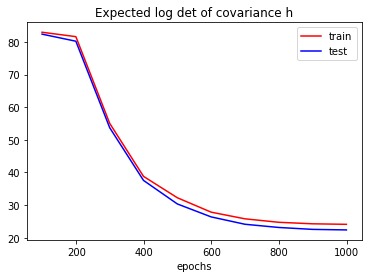

In [144]:
my_plot2(logdet_cov_h_train, logdet_cov_h_test, title = 'Expected log det of covariance h')

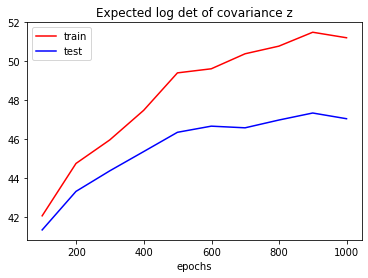

In [145]:
my_plot2(logdet_cov_z_train, logdet_cov_z_test, title = 'Expected log det of covariance z')

# Look at mutual information I(X;Z)

I(X;Z) = H(Z) - H(Z|X)

In [147]:
def plot_diff(dict1,dict2, title = 'H(Z) - H(Z|X)', label1 = 'train'):
    A = list(dict1.values())
    B = list(dict2.values())
    A_B = [A[i]-B[i] for i in range(len(A))]
    my_plot(A_B, title = title, label1 = 'train')

In [148]:
def plot_same_start(dict1,dict2, title = 'H(Z) - H(Z|X)', label1 = 'log det cov z', label2 = 'log det cov z|x'):
    A = list(dict1.values())
    B = list(dict2.values())
    A_tf = [A[i] - A[0] for i in range(len(A))]
    B_tf = [B[i] - B[0] for i in range(len(B))]
    plt.plot([99+ 100*i for i in range(10)], [A_tf[i] for i in range(10)], label = label1, color = 'r')
    plt.plot([99+ 100*i for i in range(10)], [B_tf[i] for i in range(10)], label = label2, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

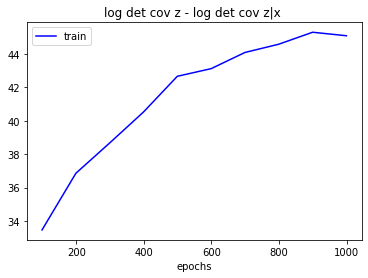

In [149]:
plot_diff(logdet_cov_z_train, logdet_cov_z_giv_x_train, title = 'log det cov z - log det cov z|x ')

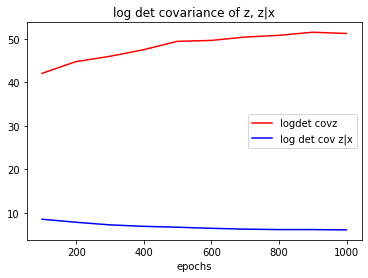

In [150]:
my_plot2(logdet_cov_z_train, logdet_cov_z_giv_x_train, label1 = 'logdet covz', label2 = 'log det cov z|x', title = 'log det covariance of z, z|x')

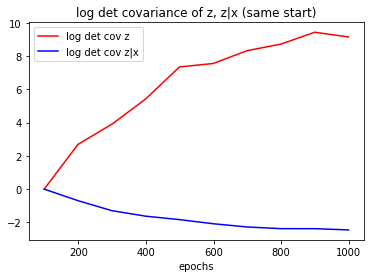

In [151]:
plot_same_start(logdet_cov_z_train, logdet_cov_z_giv_x_train, title = 'log det covariance of z, z|x (same start)', label1 = 'log det cov z', label2 = 'log det cov z|x')

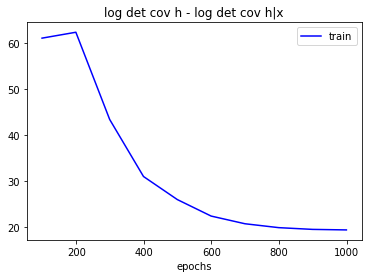

In [152]:
plot_diff(logdet_cov_h_train, logdet_cov_h_giv_x_train, title = 'log det cov h - log det cov h|x')

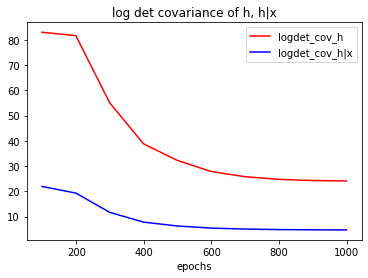

In [153]:
my_plot2(logdet_cov_h_train,logdet_cov_h_giv_x_train, label2 = 'logdet_cov_h|x', label1 = 'logdet_cov_h', title = 'log det covariance of h, h|x')

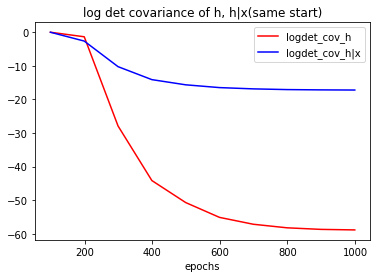

In [154]:
plot_same_start(logdet_cov_h_train, logdet_cov_h_giv_x_train, title = 'log det covariance of h, h|x(same start)',
               label1 = 'logdet_cov_h', label2 = 'logdet_cov_h|x')

## Effect of chaning batch size

In [155]:
X_train1 , X_test1 = gen_data_1pic(B = 20)
logdet_cov_h_train_20, logdet_cov_z_train_20 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


In [156]:
X_train1 , X_test1 = gen_data_1pic(B = 40)
logdet_cov_h_train_40, logdet_cov_z_train_40 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


In [157]:
X_train1 , X_test1 = gen_data_1pic(B = 60)
logdet_cov_h_train_60, logdet_cov_z_train_60 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


In [158]:
X_train1 , X_test1 = gen_data_1pic(B = 80)
logdet_cov_h_train_80, logdet_cov_z_train_80 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


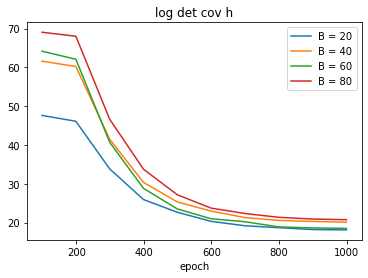

In [159]:
# estimated upper bound of the entropy depends on a batch size
A = [logdet_cov_h_train_20, logdet_cov_h_train_40, logdet_cov_h_train_60, logdet_cov_h_train_80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h')
plt.show()

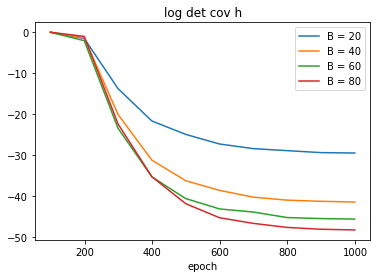

In [160]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h')
plt.show()

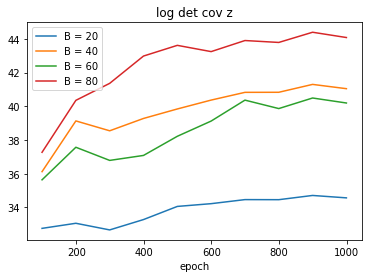

In [161]:
# estimated upper bound of the entropy depends on a batch size
A = [logdet_cov_z_train_20, logdet_cov_z_train_40, logdet_cov_z_train_60, logdet_cov_z_train_80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z')
plt.show()

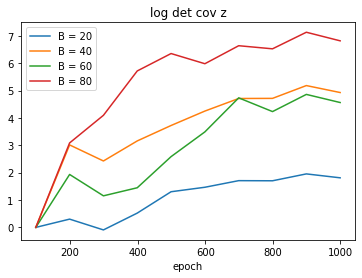

In [162]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z')
plt.show()

In [163]:
#Gendata
X_train, X_test = gen_data(B=20, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train20, logdet_cov_z_giv_x_train20 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


In [164]:
#Gendata
X_train, X_test = gen_data(B=40, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train40, logdet_cov_z_giv_x_train40 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [02:35<00:00, 15.50s/it]


In [165]:
#Gendata
X_train, X_test = gen_data(B=60, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train60, logdet_cov_z_giv_x_train60 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [03:52<00:00, 23.23s/it]


In [166]:
#Gendata
X_train, X_test = gen_data(B=80, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train80, logdet_cov_z_giv_x_train80 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [05:12<00:00, 31.25s/it]


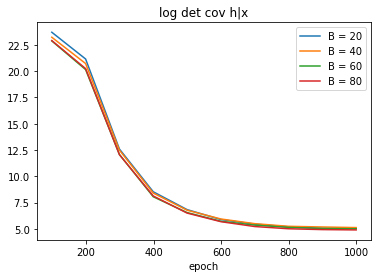

In [167]:
A = [logdet_cov_h_giv_x_train20, logdet_cov_h_giv_x_train40, logdet_cov_h_giv_x_train60, logdet_cov_h_giv_x_train80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h|x')
plt.show()

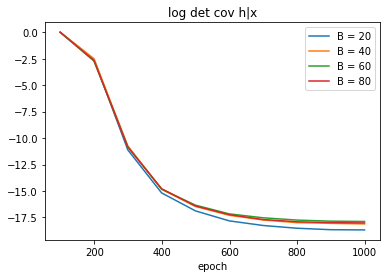

In [168]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h|x')
plt.show()

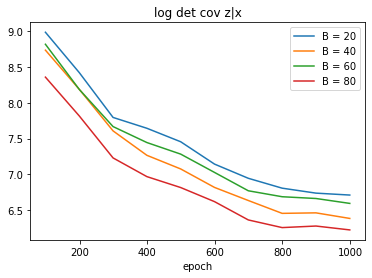

In [169]:
A = [logdet_cov_z_giv_x_train20, logdet_cov_z_giv_x_train40, logdet_cov_z_giv_x_train60, logdet_cov_z_giv_x_train80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z|x')
plt.show()

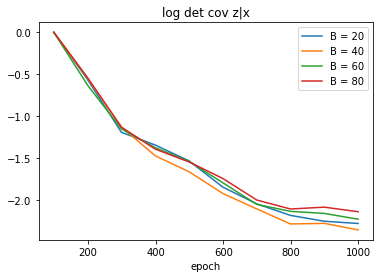

In [170]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z|x')
plt.show()

# -----------------------END---------------------

100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


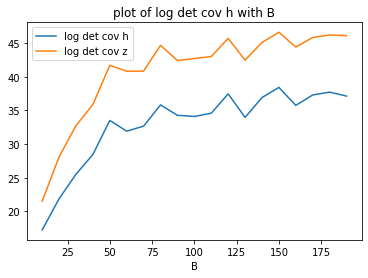

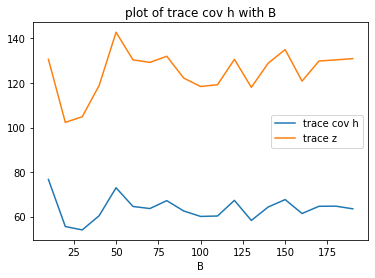

In [86]:
plt.plot(B_list, trace_H,  label = 'trace cov h')
plt.plot(B_list, trace_Z,  label = 'trace z')
plt.legend()
plt.xlabel('B')
plt.title('plot of trace cov h with B')
plt.show()

# check if my code is correct

1) check that this function h_to_cov works properly

In [88]:
multi_norm_dist = torch.distributions.MultivariateNormal(torch.tensor([[0.0, 0.0]]), 
                                                         covariance_matrix = torch.tensor([[1.0,0.0],[0.0,1.0]]))

In [89]:
trace_list = []
for i in range(1,10):
    h_test = []
    for j in range(1000*i):
        h_test.append(multi_norm_dist.sample())
    trace_list.append(cal_trace(h_to_cov(h_test)))

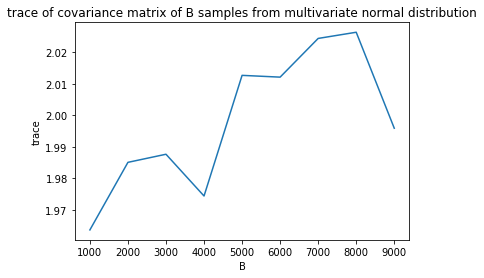

In [90]:
plt.plot([1000*i for i in range(1,10)], trace_list)
plt.xlabel('B')
plt.ylabel('trace')
plt.title('trace of covariance matrix of B samples from multivariate normal distribution')
plt.show()

# Re-do Covariance matrix h

In [37]:
B = 100
X_train1 , X_test1 = gen_data_1pic(B = B)

In [38]:
net, critics = get_net('resnet18_new.pth99')
H = x_to_h(X_train1[0], net)
H_torch = torch.stack(H).squeeze(1)

In [13]:
def h_to_cov(h):
    '''
    h = list(tensor1, tensor2, ...)
    
    return 512x512 covariance matrix 
    '''
    B = len(h)
    H_torch = torch.stack(h).squeeze(1)
    H_torch_mean = H_torch.mean(dim = 0)
    H_torch_mean = H_torch_mean.repeat(B,1)
    
    H_torch_norm = H_torch- H_torch_mean
    cov_H = 1/(B-1) * torch.matmul(H_torch_norm.transpose(0,1), H_torch_norm)
    
    return cov_H

In [14]:
def cov_to_trace(cov_H):
    '''
    return trace
    '''
    return cov_H.trace()

def cov_to_logdet(cov_H, buffer = 1):
    '''
    return logdet of covariance matrix
    '''
    return (cov_H + (torch.eye(cov_H.size()[0])).to(device)).det().log()

In [42]:
len(H)

100

In [43]:
len(H)

100

In [44]:
torch.stack(H).squeeze(1).size()

torch.Size([100, 512])

In [45]:
H_torch.size()

torch.Size([100, 512])

In [46]:
H_torch.var(0).size()

torch.Size([512])

In [47]:
trace_cov = H_torch.var(0).sum(0)
print(trace_cov)

tensor(330.1522, device='cuda:0')


In [48]:
H_torch.sum(dim = 0).size()

torch.Size([512])

In [49]:
H_torch.sum(dim = 1).size()

torch.Size([100])

In [50]:
H_torch_mean = H_torch.mean(dim = 0)
H_torch_mean = H_torch_mean.repeat(B,1)

In [51]:
H_torch_mean.size()

torch.Size([100, 512])

In [52]:
H_torch_norm = H_torch- H_torch_mean
H_torch_norm

tensor([[-0.5238, -0.4617, -0.4108,  ..., -0.5120, -0.5310, -0.1601],
        [-0.0957, -0.3593, -0.3712,  ..., -0.2216,  0.0408,  0.1538],
        [-0.0975, -0.7053,  2.9880,  ..., -0.3741, -0.2946, -0.1281],
        ...,
        [-0.6013, -0.6049,  0.7159,  ..., -0.1138,  0.9674, -0.0757],
        [ 1.3215,  1.9028,  0.0580,  ...,  1.1357, -0.4113,  0.1607],
        [ 0.6098,  0.6011, -0.8289,  ..., -0.2600,  0.4327,  0.2752]],
       device='cuda:0')

In [53]:
H_torch_norm.size()

torch.Size([100, 512])

In [54]:
H_torch_norm.transpose(0,1)

tensor([[-0.5238, -0.0957, -0.0975,  ..., -0.6013,  1.3215,  0.6098],
        [-0.4617, -0.3593, -0.7053,  ..., -0.6049,  1.9028,  0.6011],
        [-0.4108, -0.3712,  2.9880,  ...,  0.7159,  0.0580, -0.8289],
        ...,
        [-0.5120, -0.2216, -0.3741,  ..., -0.1138,  1.1357, -0.2600],
        [-0.5310,  0.0408, -0.2946,  ...,  0.9674, -0.4113,  0.4327],
        [-0.1601,  0.1538, -0.1281,  ..., -0.0757,  0.1607,  0.2752]],
       device='cuda:0')

In [55]:
H_torch_norm.transpose(0,1).matmul(H_torch_norm ).size()

torch.Size([512, 512])

In [56]:
cov_H = 1/(B-1) * torch.matmul(H_torch_norm.transpose(0,1), H_torch_norm )

In [57]:
cov_H

tensor([[ 0.4535,  0.1079,  0.0456,  ...,  0.0795, -0.0667,  0.0414],
        [ 0.1079,  0.7365, -0.2183,  ...,  0.0977, -0.0356,  0.1158],
        [ 0.0456, -0.2183,  1.0031,  ...,  0.0854,  0.0158,  0.0175],
        ...,
        [ 0.0795,  0.0977,  0.0854,  ...,  0.1650,  0.0032,  0.0642],
        [-0.0667, -0.0356,  0.0158,  ...,  0.0032,  0.1950, -0.0372],
        [ 0.0414,  0.1158,  0.0175,  ...,  0.0642, -0.0372,  0.1494]],
       device='cuda:0')

In [58]:
cov_H.size()

torch.Size([512, 512])

In [59]:
cov_H.trace()

tensor(330.1522, device='cuda:0')

In [60]:
trace_cov = H_torch.var(0).sum(0)
print(trace_cov)

tensor(330.1522, device='cuda:0')


In [61]:
cov_H.det()

tensor(0., device='cuda:0')

In [62]:
cov_H

tensor([[ 0.4535,  0.1079,  0.0456,  ...,  0.0795, -0.0667,  0.0414],
        [ 0.1079,  0.7365, -0.2183,  ...,  0.0977, -0.0356,  0.1158],
        [ 0.0456, -0.2183,  1.0031,  ...,  0.0854,  0.0158,  0.0175],
        ...,
        [ 0.0795,  0.0977,  0.0854,  ...,  0.1650,  0.0032,  0.0642],
        [-0.0667, -0.0356,  0.0158,  ...,  0.0032,  0.1950, -0.0372],
        [ 0.0414,  0.1158,  0.0175,  ...,  0.0642, -0.0372,  0.1494]],
       device='cuda:0')

In [63]:
#det
(cov_H + (torch.eye(512)).to(device)).det().log()

tensor(73.6733, device='cuda:0')

In [64]:
cov_H

tensor([[ 0.4535,  0.1079,  0.0456,  ...,  0.0795, -0.0667,  0.0414],
        [ 0.1079,  0.7365, -0.2183,  ...,  0.0977, -0.0356,  0.1158],
        [ 0.0456, -0.2183,  1.0031,  ...,  0.0854,  0.0158,  0.0175],
        ...,
        [ 0.0795,  0.0977,  0.0854,  ...,  0.1650,  0.0032,  0.0642],
        [-0.0667, -0.0356,  0.0158,  ...,  0.0032,  0.1950, -0.0372],
        [ 0.0414,  0.1158,  0.0175,  ...,  0.0642, -0.0372,  0.1494]],
       device='cuda:0')

In [65]:
my_cov = h_to_cov(H)
my_cov

tensor([[ 0.4535,  0.1079,  0.0456,  ...,  0.0795, -0.0667,  0.0414],
        [ 0.1079,  0.7365, -0.2183,  ...,  0.0977, -0.0356,  0.1158],
        [ 0.0456, -0.2183,  1.0031,  ...,  0.0854,  0.0158,  0.0175],
        ...,
        [ 0.0795,  0.0977,  0.0854,  ...,  0.1650,  0.0032,  0.0642],
        [-0.0667, -0.0356,  0.0158,  ...,  0.0032,  0.1950, -0.0372],
        [ 0.0414,  0.1158,  0.0175,  ...,  0.0642, -0.0372,  0.1494]],
       device='cuda:0')

# test function with multivariate normal dist

In [66]:
multi_norm_dist = torch.distributions.MultivariateNormal(torch.zeros([1, 3]), 
                                                         covariance_matrix = torch.eye(3))

In [67]:
torch.tensor([[0.0, 0.0]]).size()

torch.Size([1, 2])

In [68]:
cov_list = []
trace_list = []
logdet_list = []
for i in range(1,50):
    h_test = []
    for j in range(100*i):
        h_test.append(multi_norm_dist.sample().to(device))
    a = h_to_cov(h_test)
    b = cov_to_trace(a)
    c = cov_to_logdet(a, buffer = 0.1)
    cov_list.append(a)
    trace_list.append(b)
    logdet_list.append(c)

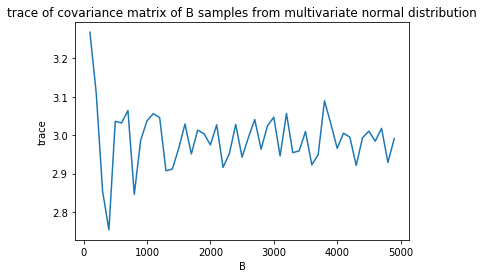

In [69]:
plt.plot([100*i for i in range(1,50)], trace_list)
plt.xlabel('B')
plt.ylabel('trace')
plt.title('trace of covariance matrix of B samples from multivariate normal distribution')
plt.show()

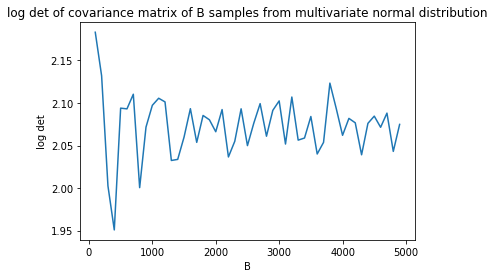

In [70]:
plt.plot([100*i for i in range(1,50)], logdet_list)
plt.xlabel('B')
plt.ylabel('log det')
plt.title('log det of covariance matrix of B samples from multivariate normal distribution')
plt.show()

In [71]:
cov_list[0]

tensor([[1.4126, 0.0194, 0.0977],
        [0.0194, 0.9828, 0.1644],
        [0.0977, 0.1644, 0.8727]], device='cuda:0')

In [72]:
cov_list[20]

tensor([[ 1.0372, -0.0158, -0.0314],
        [-0.0158,  1.0050, -0.0312],
        [-0.0314, -0.0312,  0.9850]], device='cuda:0')

In [73]:
cov_list[40]

tensor([[ 1.0073, -0.0200,  0.0183],
        [-0.0200,  1.0020,  0.0145],
        [ 0.0183,  0.0145,  0.9962]], device='cuda:0')

# Test with h,z

In [74]:
B = 100
X_train1 , X_test1 = gen_data_1pic(B = B)
net, critics = get_net('resnet18_new.pth99')
H = x_to_h(X_train1[0], net)
Z = h_to_z(H, critics)

In [75]:
cov_H = h_to_cov(H)
cov_Z = h_to_cov(Z)

In [76]:
cov_H.size()

torch.Size([512, 512])

In [77]:
cov_Z.size()

torch.Size([128, 128])

In [78]:
cov_to_logdet(cov_H)

tensor(73.0517, device='cuda:0')

In [79]:
cov_to_logdet(cov_Z)

tensor(38.3318, device='cuda:0')

# calculate h|x ?

In [15]:
B = 10
X_train, X_test = gen_data(B = B, sample = 20)

In [16]:
len(X_train)

10

In [17]:
len(X_train[0])

20

In [24]:
X = X_train
net, critics = get_net('resnet18_new.pth99')
cov_H = []
cov_Z = []
for i in range(len(X)):
    x_i = X[i]
    h_i = x_to_h(x_i, net)
    z_i = h_to_z(h_i, critics)
    cov_h_i = h_to_cov(h_i) # calculate covariance matrix
    cov_z_i = h_to_cov(z_i)
    
    cov_H.append(cov_h_i)
    cov_Z.append(cov_z_i)

In [26]:
trace_H = []
trace_Z = []
for i in range(len(cov_H)):
    cov_h_i = cov_H[i]
    trace_H.append(cov_to_trace(cov_h_i))

for i in range(len(cov_Z)):
    cov_z_i = cov_Z[i]
    trace_Z.append(cov_to_trace(cov_z_i))
    

In [35]:
trace_H

[tensor(114.4523, device='cuda:0'),
 tensor(50.7732, device='cuda:0'),
 tensor(43.7620, device='cuda:0'),
 tensor(47.4791, device='cuda:0'),
 tensor(89.1422, device='cuda:0'),
 tensor(46.3529, device='cuda:0'),
 tensor(78.1492, device='cuda:0'),
 tensor(78.6165, device='cuda:0'),
 tensor(48.5014, device='cuda:0'),
 tensor(66.0228, device='cuda:0')]

In [33]:
torch.tensor(trace_H).size()

torch.Size([10])

In [34]:
torch.tensor(trace_H).mean()

tensor(66.3252)

In [37]:
torch.tensor(trace_H).std()

tensor(23.4533)

In [19]:
cov_H[0].size()

torch.Size([512, 512])

In [20]:
len(cov_H)

10

In [22]:
cov_Z[0].size()

torch.Size([128, 128])